# How do I develop an optimal strategy for sending a personal message to each of my customers?

## Goals (7 min)

Several problems in the industry nowadays have the form:

> "Which of these $M$ products should I offer to customers with $X$ characteristics?". 

For instance, "What movie $M$ should I recommend to an user that has watched $X$ movies in the last couple of days?", "Which of these $M$ ads should I play after user $X$ finished this video?", etc. In order to solve these types of problems one usually implements an experiment by:

   1. Selecting a small sample of the total customer base
   2. Offering some of the $M$ products to the sample at random or based on previous knowledge of the population 
   3. Recording the outcome of the offerings and track the positive/negative responses of the customers
   4. Use the results above to create a plausible *strategy* to offer the products to the rest of the customers
   5. Optionally, repeat the process with a larger sample using the knowledge we have gained so far

One must carefully answer certain design questions when implementing experiments like this. For instance: *"How shall we choose our initial sample?"*, *"How do we determine whether a customer response is positive?"*, *"What strategy is the best to follow?"*, *"How do we estimate the response rate of our strategy for our entire customer base?"*. In this case, you will learn how to properly attack these questions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt

## Introduction (5 min)

**Business Context.** You are a data scientist at a large tech firm. You want to send a personalized email message to each person on your firm's mailing list to advertise the launch of a new service. The goal of this campaign is to maximize long-term engagement with this new service.

One naive strategy would be to bombard each subscriber with messages of all types. However, this would violate the company's agreement with its email subscribers which limits the number of messages sent per week, and would also likely be harmful as members unsubscribe due to the burden of dealing with too many messages. Thus, for the purpose of this campaign, we will assume that we can send each subscriber at most one message, which will be selected from a predetermined set of message types.

**Business Problem.** The firm wants you to answer the following: **"For any given customer, which message out of our predetermined set of message types should we send to that customer to optimize long-term engagement with our new service?"**

**Analytical Context.** Designing and evaluating the effectiveness of an intervention (e.g. sending a personalized advertisement) is a fundamental application of data science. In this case study, we will learn to solve the preceding problem through careful design of an experiment and careful consideration of causal effects. 

The case is structured as follows: you will (1) precisely define the objectives by which we want to evaluate the results of our experiment; (2) set up our experiment via appropriate sampling and assignment of messages; and (3) evaluate the outcomes using our custom-designed metric.

## Defining our objectives (35 min)

We assume that there is pool of subcribers $\mathcal{S} = \left\lbrace 1,\ldots, S\right\rbrace$ and for each subscriber we have a vector of $p$ attributes (features) $\mathbf{X}_s = (X_{s,1},\ldots, X_{s,p})$, for $s=1,\ldots, S$. Examples of such attributes might include purchase history, response rate to previous advertisements, relationship depth, as well as demographic and geographic information. 

n addition, there is a pool of potential email messages $\mathcal{M} = \left\lbrace 1,\ldots, M\right\rbrace$ that we could send to each subscriber. A personalized messaging strategy will involve sending a single message from this set based on the attributes of a particular subscriber. For example, we might consider a strategy like:

* **IF** subscriber is less than 31 years old **THEN** send them Message 1<br>
* **ELSE IF** subscriber has responded previously to email advertisements **THEN** send them Message 2<br>
* **ELSE IF** subscriber has Platinum status **THEN** send them Message 3<br>
* **ELSE** send them Message 4.<br>


In many situations, the dimension $p$ of the feature vector $\mathbf{X}$ and the number $M$ of possible messages can be large.  However, for the purposes of this case, the subscribers in our dataset have only $p=1$ feature (a previously calculated *Marketing Indicator* of each subscriber) and there is a total of $M=2$ possible messages we planed to send (we will deal with more general instances when studying classifier algorithms in future cases). 
    
Let us load the data and take a quick look at the *Marketing Indicator* vector of our subscribers. Our dataset also contains a pair of columns (namely the columns 'Message Sent' and 'Response') that we will study later in the case. 

In [48]:
marketing_data=pd.read_csv('marketing_data.txt',sep=' ',names=['Marketing Indicator','Message Sent','Response'])
marketing_data.index = marketing_data.index.set_names(['Subject'])
marketing_data['Marketing Indicator'].head(10).reset_index()

,Subject,Marketing Indicator
0,0,0.017993
1,1,-1.128283
2,2,-0.948344
3,3,-1.263382
4,4,5.898748
5,5,-0.585778
6,6,3.107938
7,7,-1.120899
8,8,-1.219169
9,9,-0.721018


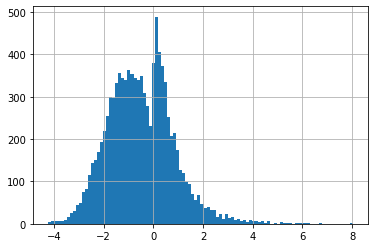

In [5]:
marketing_data['Marketing Indicator'].hist(bins=100)

In [47]:
marketing_data['Marketing Indicator'].describe()

count    10000.000000
mean        -0.482051
std          1.324813
min         -4.222422
25%         -1.416866
50%         -0.543958
75%          0.337416
max          8.018350
Name: Marketing Indicator, dtype: float64

### Exercise 1: (10 min)

For the sake of concreteness, suppose that the new service offers streaming videos that users can watch either by paying per video or by signing up for an annual subscription.

#### 1.1

What are some possible measures of engagement that we might use as our outcome?

**Answer.** Some outcomes we might consider are:

1. Total number of videos watched 
2. Total number of subscriptions
3. Total revenue (profit) 
4. Regular engagement (rate of unique visits) 

Determining which measures are better than others will depend on the revenue model for the service. If advertising dollars is a key component, then perhaps we should try to maximize the number of visits or time spent viewing (thereby maximizing advertiser exposure).  This might also be a reasonable outcome to measure if the goal were to build a user base (possibly at a revenue loss) which will be monetized later. On the other hand, if revenue is generated primarily through subscriptions and video purchases, then some combination of videos watched and subscriptions might be an appropriate outcome to track.

#### 1.2

Suppose that the company believes that a user will only subscribe to the service if they have determined that it provides worthwhile savings over the pay-per-video model. Assuming this perspective, what might be a good outcome to measure?

**Answer.** Total video views and unique site visits would be defensible outcomes to measure here. These also have the advantage of being measurable shortly after the messages are sent out. If subscriptions only follow regular pay-per-video use, then we may have to wait a long time to obtain feedback about the effectiveness of the messages.

### Quantifying our outcomes

We want to construct an optimal messaging strategy; however, prior to sending any messages we have no knowledge about the effectiveness of any of the messages. Thus, it is sensible to use a **subset** of the population $\mathcal{S}_0 \subseteq \mathcal{S}$ to learn about which messages are effective and subsequently construct a **strategy** $\pi$ that takes the features of our customers and help us to decide which message to send to the remainder of the population.

We want to maximize engagement shortly after launch, so we will use an outcome that is immediately measurable: 
an indicator that the user followed a link (embedded in each message) to the new service's homepage within 
36 hours of the message being sent. For each $s \in \mathcal{S}_0$ we will observe a feature vector $\mathbf{X}_s$, a message $M_s\in \mathcal{M}$ sent to the subscriber and a binary outcome $Y_s = 0$ or $Y_s = 1$ indicating whether the subscriber clicked on the embedded link within 36 hours or not.

### Exercise 2: (10 min)

Suppose that after obtaining the result data $\{X_s,M_s,Y_s\}_{s\in \mathcal{S}_0}$ from our initial sample, we have come up with a strategy $\pi$ that assigns a message based on a subject's features $\mathbf{X}$. Construct a metric that would allow you to estimate the response rate of $\pi$ in the entire population $\mathcal{S}$.

**Answer.** One approach would be to simply take the mean response rate among subjects that were sent a messsage which is consistent with that prescribed by $\pi$. For example, if $\pi$ were to assign all subjects to Message 1, then we would just take the response rate among all subjects which were given Message 1. That is, let $Z_s = 1$ if subject $j$ received Message 1 and $Z_s = 0$ if they received one of the other messages, then in equation form this metric would be:

$$
\frac{
\sum_{s\in\mathcal{S}_0}Z_sY_s
}{
\sum_{s\in\mathcal{S}_0}Z_s
}.
$$ 

More generally, for any strategy $\pi$ we can define $Z_s^{\pi} = 1$ if $M_s = \pi(\mathbf{X}_s)$ and 
$Z_s^{\pi} = 0$ otherwise. Our estimator of the mean response rate under $\pi$ is then:

$$
\mu(\pi) = \frac{
    \sum_{s\in\mathcal{S}_0}Z_s^{\pi}Y_s
}{
    \sum_{s\in\mathcal{S}_0}Z_s^{\pi}
}.
$$

This formula might look complicated, but we're simply taking the mean response rate among all subjects that were assigned a message that is consistent with the recommendation prescribed by $\pi$.  

### Exercise 3: (10 min)

To make the results of Exercise 2 concrete, let's consider a small example. Suppose that our initial batch $\mathcal{S}_{0}$ consists of 20 randomly selected subscribers of our marketing data. After sending messages to this batch we obtained the following results:

In [43]:
np.random.seed(0) #Added just for the sake of replication

S_0=np.random.randint(0,10000,20)
first_batch=marketing_data.iloc[S_0,:]
first_batch

,Marketing Indicator,Message Sent,Response
Subject,,,
2732,-0.169603,0,0
9845,0.029417,1,0
3264,-2.235855,0,0
4859,0.145138,1,0
9225,0.182082,0,1
7891,-2.383956,1,1
4373,-0.471215,1,0
5874,-1.040592,1,0
6744,-1.784661,0,0


#### 3.1

Suppose that we wish to evaluate the strategy $\pi$ given by
    
$$
\pi(x)= 1 \quad  \text{if $x < 0$,} \quad \quad \quad   \pi(x) = 0  \quad \text{if $x\geq 0$.}
$$

We have labeled the first 10 observations according to whether or not the observation is consistent with $\pi$; e.g. in the first row $X = -0.169603$ and $M = 0$ but $\pi(X) = 1$ so it is not consistent, but in the second row $X = -0.1$ and $M = 1$ which is consistent with $\pi(-0.1) = 1$. Label the last ten rows according to whether or not the observations are consistent with this definition of $\pi$.

|    Marketing Indicator |   Message Sent |   Response |   $\pi$ | Consistent with $\pi$|
| ----------------------:|---------------:|-----------:|-------:|---------------------:|
|             -0.169603  |              0 |          0 |    1   | No|
|              0.029417  |              1 |          0 |    0   |No|
|             -2.23586   |              0 |          0 |    1   |No|
|              0.145138  |              1 |          0 |    0   |No|
|              0.182082  |              0 |          1 |    0   |Yes|
|             -2.38396   |              1 |          1 |    1   |Yes|
|             -0.471215  |              1 |          0 |    1   |Yes|
|             -1.04059   |              1 |          0 |    1 |Yes|
|             -1.78466   |              0 |          0 |    1 |No|
|             -1.68022   |              0 |          0 |    1 |No|
|              0.0422555 |              0 |          1 |    0 |?|
|              0.518685  |              1 |          0 |    0 |?|
|              0.680522  |              1 |          1 |    0 |?|
|             -2.03424   |              0 |          0 |    1 |?|
|             -1.33342   |              1 |          1 |    1 |?|
|             -0.642355  |              1 |          0 |    1 |?|
|              0.396984  |              1 |          0 |    0 |?|
|             -0.377838  |              1 |          0 |    1 |?|
|             -1.62844   |              1 |          0 |    1 |?|
|             -0.944289  |              1 |          0 |    1 |?|

**Answer.** The completed table is:

|    Marketing Indicator |   Message Sent |   Response |   $\pi$ | Consistent with $\pi$|
| ----------------------:|---------------:|-----------:|-------:|---------------------:|
|             -0.169603  |              0 |          0 |    1   | No|
|              0.029417  |              1 |          0 |    0   |No|
|             -2.23586   |              0 |          0 |    1   |No|
|              0.145138  |              1 |          0 |    0   |No|
|              0.182082  |              0 |          1 |    0   |Yes|
|             -2.38396   |              1 |          1 |    1   |Yes|
|             -0.471215  |              1 |          0 |    1   |Yes|
|             -1.04059   |              1 |          0 |    1 |Yes|
|             -1.78466   |              0 |          0 |    1 |No|
|             -1.68022   |              0 |          0 |    1 |No|
|              0.0422555 |              0 |          1 |    0 |Yes|
|              0.518685  |              1 |          0 |    0 |No|
|              0.680522  |              1 |          1 |    0 |No|
|             -2.03424   |              0 |          0 |    1 |No|
|             -1.33342   |              1 |          1 |    1 |Yes|
|             -0.642355  |              1 |          0 |    1 |Yes|
|              0.396984  |              1 |          0 |    0 |No|
|             -0.377838  |              1 |          0 |    1 |Yes|
|             -1.62844   |              1 |          0 |    1 |Yes|
|             -0.944289  |              1 |          0 |    1 |Yes|

#### 3.2

Compute $\mu(\pi)$ for the above table.

**Answer.** To compute $\mu(\pi)$ we simply average the outcomes among those that were consistent with the recommended prescription of our strategy $\pi$; i.e., the outcomes of subjects 5, 6, 7, 8, 11, 15, 16, 18, 19 and 20. Among these subjects, the responses are $1, 1, 0, 0, 1, 1, 0, 0, 0, 0$ the average of which is $2/5$.

## Setting up our experiment (20 min)

### Choosing our population sample

In order for our experiment to recommend a course of action that is applicable to the entire population, the individuals in the sample of subjects we collect data on must be similar to those in the rest of the population. How can we ensure that this will be true?

As a first step toward answering this question, let's consider a few scenarios under which this might *not* be true:

### Exercise 4: (5 min)

Suppose first that we ordered our subjects according to how long they had been subscribers to our email list and selected $\mathcal{S}_0$ by simply taking the first $S_0$ people from this list; i.e. the $S_0$ subscribers with the longest active subscriptions. What are the potential pitfalls of this sampling method?

**Answer.** Long-time active subscribers may over-represent individuals who have a deep relationship with the company. Therefore, they may respond at a higher rate to any messages sent by the company and may also respond differently to different types of messages. For example, a customer with a deep relationship may be more responsive to detail-oriented messages or those referencing existing offerings with which the customer is already familiar. However, customers with a more shallow relationship may be unwilling to read a detailed message and/or may be unfamiliar with the company's other offerings.

### Exercise 5: (5 min)

How would you choose the subset of customers to include in $\mathcal{S}_0$? What are all the factors you would want to control for?

**Answer.** The preceding question raises questions about how we should choose the subset of subscribers from which to estimate the effectiveness of the different messages. We might consider **stratifying** the population into **strata** based on relationship duration to ensure we have the same proportion of longtime users in the sample $\mathcal{S}_0$ as in the entire population $\mathcal{S}$ as well as the same proportions of short time and medium-time users in $\mathcal{S}_0$ as in $\mathcal{S}$ etc.

However, there are other factors like user geography or demographics that may be important to stratify by. For example, we shouldn't include a disproportionate set of males in our sample, or include too many citizens from Bogota, or only senior citizens, etc. In practice, a good way to figure out what factors to stratify by is to identify perceived relationships between these characteristics and outcomes based on anecdotal evidence and your initial EDA of the data.

### Delivering our messages

Suppose we have stratified our population as indicated above. Then the next step is to randomly sample from each strata in the correct proportions. This ensures that our sample $\mathcal{S}_0$ does not disproportionately represent any subset of citizens which we believe may display materially different behaviors relative to the average member of $\mathcal{S}$. This method is known as **stratified sampling**.

### Exercise 6: (5 min)

Having drawn our sample $\mathcal{S}_0$, how should we assign the messages? Can you imagine a way in which messages might be assigned that would bias our results?

**Answer.** We have many of the same risks with message assignments as we had when constructing the sample $\mathcal{S}_0$. Suppose, for example, that customers who are more likely to respond to *any* message are assigned to Message 1 and the remainder are assigned to Message 2. Then Message 1 might appear to be more effective than Message 2 even if Message 2 is more effective on the population as a whole. (This is a classic example of Simpson's Paradox!) Some factors that could bias response rate include prior response to similar messages, relationship depth, or subscriber attributes associated with the new product being advertised. To avoid such biases, we can perform random assignment of messages to individuals within each strata that we identified during our customer sampling step.

## Evaluating our strategies (15 min)

After executing our strategies, our resulting data will be of the form $\left\lbrace \mathbf{X}_s, M_s, Y_s\right\rbrace_{s\in\mathcal{S}_0}$ as described in the opening to this case. Now, given any messaging strategy, $\pi$, we can use our formula from Exercise 2 to evaluate its effectiveness on the entire population $\mathcal{S}$.  

### Exercise 7: (15 min)

Our `marketing_data` DataFrame contains $\left\lbrace \mathbf{X}, M, Y\right\rbrace$ triples of the form described in this case (with column names 'Marketing Indicator', 'Message Sent' and 'Response' respectively). Assuming that the message type $M$ was randomly assigned with a coin toss and the observed random sample is a stratified random sample of the population of subscribers, perform the following tasks:

1. Estimate the mean outcome if all subjects were assigned Message 1 by the strategy $\pi$.
2. Estimate the mean outcome if all subjects were assigned Message 0 by the strategy $\pi$.
3. Estimate an optimal strategy $\pi$ of the form: give Message 1 if $X > \tau$ and Message 0 otherwise; i.e. find the best threshold value for $\tau$

**Answer.** For parts 1 and 2, we can read in the table and apply our formula:

In [45]:
# Copy to separate vectors for readability 
X = np.array(marketing_data['Marketing Indicator']) 
M = np.array(marketing_data['Message Sent'])
Y = np.array(marketing_data['Response'])

# Compute the mean under the rule assign all to message one
mean_msg_one = np.sum(Y*M)/np.sum(M)
print("Estimated mean under Message 1: ", mean_msg_one)

# Compute the mean under the rule assign all to message zero
mean_msg_zero = np.sum(Y*(1-M))/np.sum(1-M)
print("Estimated mean under Message 0: ", mean_msg_zero)

Estimated mean under Message 1:  0.23609144244386002
Estimated mean under Message 0:  0.3583152066442555


_______

The preceding result suggests that Message 0 is considered more effective than Message 1, on the order of 12%. Now let's look over a grid of $\tau$ values to estimate the optimal strategy:

In [46]:
# We'll search over tau values between the lower 5 percentile and upper 95 percentile
# of the distn of X:
tau_lower = np.percentile(X, 5)
tau_upper = np.percentile(X, 95)
tau_seq = np.arange(tau_lower, tau_upper, 0.01)
opt_tau = None 
opt_value = -np.inf 
for tau in tau_seq:
    comply_with_rule = (X > tau).astype(int)*M + (X <= tau).astype(int)*(1-M)
    mean_under_rule = np.sum(Y*comply_with_rule)/np.sum(comply_with_rule)
    if mean_under_rule >= opt_value:
        opt_value = mean_under_rule
        opt_tau = tau
print("Optimal tau: ", opt_tau)
print("Optimal value: ", opt_value)

Optimal tau:  0.5228188361086299
Optimal value:  0.3862233724865618


Our estimated optimal rule recommends assigning Message 1 to subscribers with $X > 0.522$ and Message 0 otherwise. This is estimated to yield approximately a 3% improvement over assigning all subjects to Message 0.

## Conclusions (3 min)

In this case, we looked at how to construct email messaging strategies through a randomized experiment. Our randomized experiment used a small subset of a large pool of subscribers to identify an optimal messaging strategy and then applied this strategy to the remaining customers. Using the sample data, we found that even though one message was markedly better than the other, tailoring the exact message we send to a subscriber's specific characteristics (even sometimes sending them the "worse" message) led to even better results. 

## Takeaways (5 min)

In this case, you learned about proper experimental design when testing several possible courses of action. In particular, the following principles are key for such designs:

1. It is key to pre-identify intrinsic characteristics of sub-segments of the population that could bias outcomes. These should be used to pre-stratify the population before doing any sampling.
2. Once the strata are identified, randomization is a key tool to avoid systematic bias in sampling from each strata. This is known as stratified sampling.
3. The response rate of strategies for the entire customer base is extremely important to avoid response bias. One should estimate the likely response rate and how it influences the design of optimal strategies. 